In [14]:
from db_helper import DBHelper
import datetime
import networkx as nx
from node2vec import Node2Vec
from datetime import datetime
import gensim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import importlib

In [67]:
import graph_constructor as GC

In [21]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [4]:
db = DBHelper()
db.connect(user="root",passwd="Hasan5695*",db="cse496")

In [5]:
tweets = db.getTweets("denemeShort")
tweets.sort(key=lambda t: t.date)

In [6]:
#Print first tweet
print("ExampleSentName:",tweets[0].sentName)
print("ExampleText:",tweets[0].text)
print("ExampleDate:",tweets[0].date)

ExampleSentName: osmancoskungazi
ExampleText: Hayat bu, bir bakarsın herşey bir anda son bulur.
 Hayat bu, son dediğin an herşey yeniden can bulur..Şemsi Tebrizi
ExampleDate: 2013-06-25 16:24:47


In [17]:
startTime = datetime.now()
G_time1 = GC.create_time_graph1(tweets)
endTime = datetime.now()
print("Time1 Graph construct time: ",endTime-startTime)
print("Number of edges: ",G_time1.number_of_edges())
print("Number of nodes: ",G_time1.number_of_nodes())

Time1 Graph construct time:  0:00:00.747057
Number of edges:  465
Number of nodes:  51


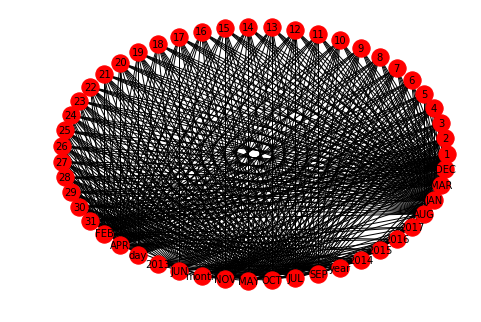

In [18]:
pos=nx.circular_layout(G_time1)
#nx.draw(G,width=1,node_size=300,font_size=10,with_labels=True)
nx.draw(G_time1,pos,node_size=300,font_size=10,with_labels=True)

In [48]:
# train, create new node2ve model
G_time1N2V = Node2Vec(G_time1, dimensions=64, walk_length=1, num_walks=200, workers=2) 

Generating walks (CPU: 2): 100%|██████████| 100/100 [00:00<00:00, 4265.15it/s]


In [59]:
# run/fit word2vec algorithm and get wv model
G_time1_model = G_time1N2V.fit(window=5, min_count=10, batch_words=4)

In [60]:
G_time1_model.wv.save_word2vec_format("../outputs/G_time1_model_wv_format")

# Save model for later use
G_time1_model.save("../outputs/G_time1_model")

In [61]:
G_time1_model.wv.most_similar("3")

[('6', 0.280364990234375),
 ('2015', 0.22149144113063812),
 ('4', 0.1674255132675171),
 ('8', 0.14420706033706665),
 ('22', 0.14078345894813538),
 ('13', 0.1403978019952774),
 ('MAY', 0.13969001173973083),
 ('JUL', 0.13323450088500977),
 ('20', 0.1316586583852768),
 ('27', 0.13015948235988617)]

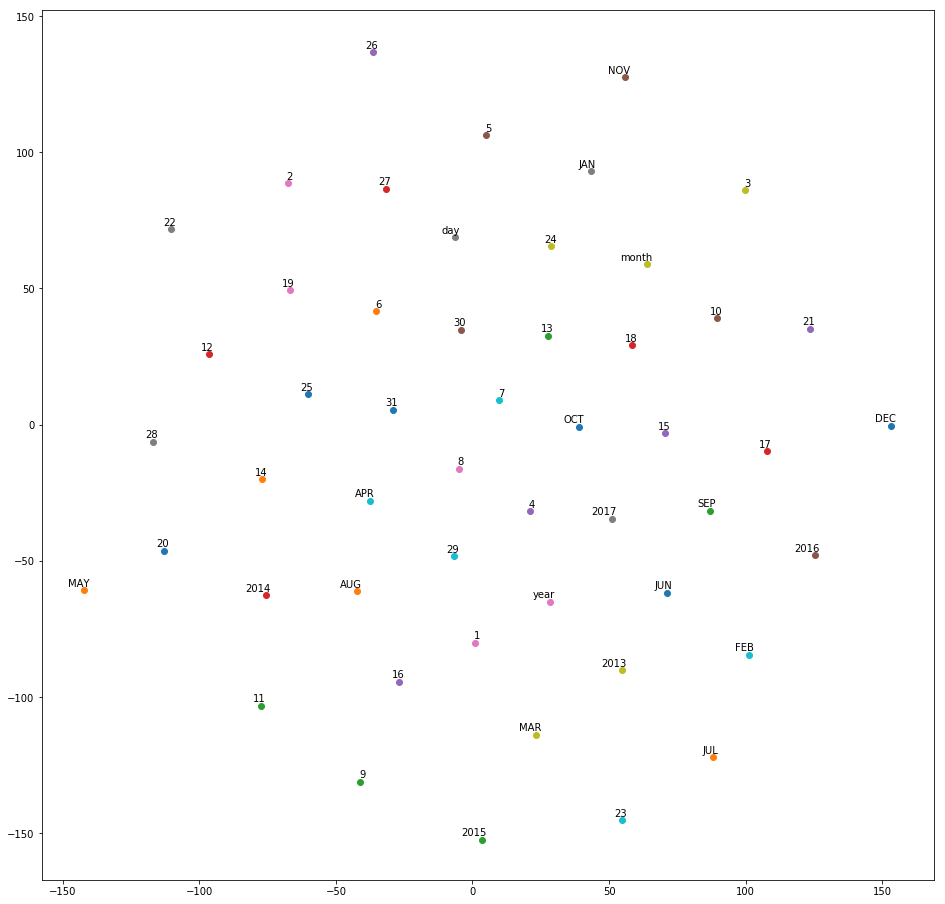

In [52]:
tsne_plot(G_time1_model)

In [70]:
# Get random sorted tweets and draw graph
importlib.reload(GC)
startTime = datetime.now()
G_time2 = GC.create_time_graph2(tweets)
endTime = datetime.now()
print("Time2 Graph construct time: ",endTime-startTime)
print("Number of edges: ",G_time2.number_of_edges())
print("Number of nodes: ",G_time2.number_of_nodes())

Time2 Graph construct time:  0:00:00.699760
Number of edges:  157
Number of nodes:  58


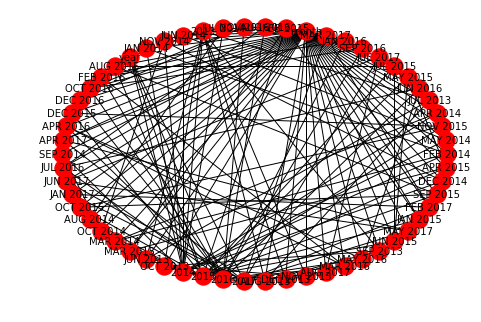

In [74]:
pos=nx.circular_layout(G_time2)
#nx.draw(G3,width=1,node_size=300,font_size=10,with_labels=True)
nx.draw(G_time2,pos,node_size=300,font_size=10,with_labels=True)

In [75]:
# train, create new node2ve model
G_time2N2V = Node2Vec(G_time2, dimensions=64, walk_length=2, num_walks=1000, workers=3) 

Generating walks (CPU: 3): 100%|██████████| 333/333 [00:00<00:00, 346.13it/s]


In [76]:
# run/fit word2vec algorithm and get wv model
G_time2_model = G_time2N2V.fit(window=10, min_count=1, batch_words=4)

In [77]:
G_time2_model.wv.save_word2vec_format("../outputs/G_time2_model_wv_format")

# Save model for later use
G_time2_model.save("../outputs/G_time2_model")

In [78]:
G_time2_model.wv.most_similar("2013")

[('SEP 2013', 0.9654965400695801),
 ('NOV 2013', 0.9572229981422424),
 ('JUL 2013', 0.9409128427505493),
 ('OCT 2013', 0.9074794054031372),
 ('DEC 2013', 0.8977060317993164),
 ('AUG 2013', 0.8953660130500793),
 ('JUN 2013', 0.8865481615066528),
 ('year', 0.7282577753067017),
 ('month', 0.6635309457778931),
 ('JAN 2014', 0.5019360780715942)]

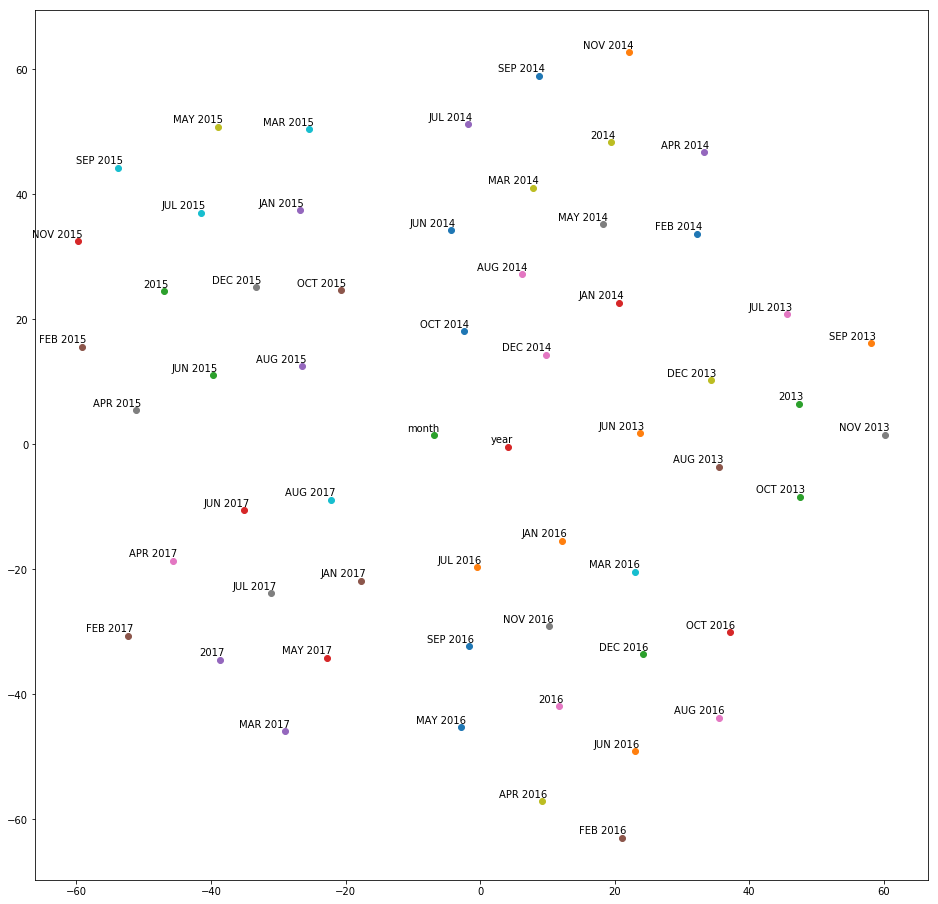

In [79]:
tsne_plot(G_time2_model)

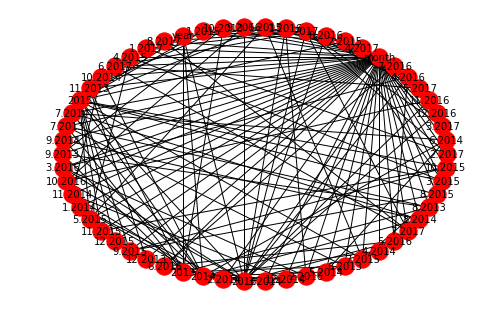

In [86]:
pos=nx.circular_layout(G_time3)
#nx.draw(G3,width=1,node_size=300,font_size=10,with_labels=True)
nx.draw(G_time3,pos,node_size=300,font_size=10,with_labels=True)

In [97]:
# Get random sorted tweets and draw graph
importlib.reload(GC)
startTime = datetime.now()
G_time3 = GC.create_time_graph3(tweets[:1000])
endTime = datetime.now()
print("Time3 Graph construct time: ",endTime-startTime)
print("Edges #:",G_time3.number_of_edges()," Nodes #: ",G_time3.number_of_nodes())

Time3 Graph construct time:  0:00:00.022340
Edges #: 879  Nodes #:  307


In [98]:
# train, create new node2ve model
G_time3N2V = Node2Vec(G_time3, dimensions=64, walk_length=2, num_walks=1000, workers=3) 

Generating walks (CPU: 3): 100%|██████████| 333/333 [00:05<00:00, 58.97it/s]


In [99]:
# run/fit word2vec algorithm and get wv model
G_time3_model = G_time3N2V.fit(window=10, min_count=1, batch_words=4)

In [100]:
G_time3_model.wv.save_word2vec_format("../outputs/G_time3_model_wv_format")

# Save model for later use
G_time3_model.save("../outputs/G_time3_model")

In [101]:
G_time3_model.wv.most_similar("2013")

[('month', 0.7091671228408813),
 ('2015', 0.6960493326187134),
 ('25.6.2013', 0.6669191122055054),
 ('14.10.2013', 0.6412636041641235),
 ('28.7.2013', 0.6306208372116089),
 ('24.8.2013', 0.6184573769569397),
 ('5.9.2013', 0.617465078830719),
 ('16.11.2013', 0.5769343376159668),
 ('JUL.2013', 0.5764925479888916),
 ('year', 0.5711523294448853)]

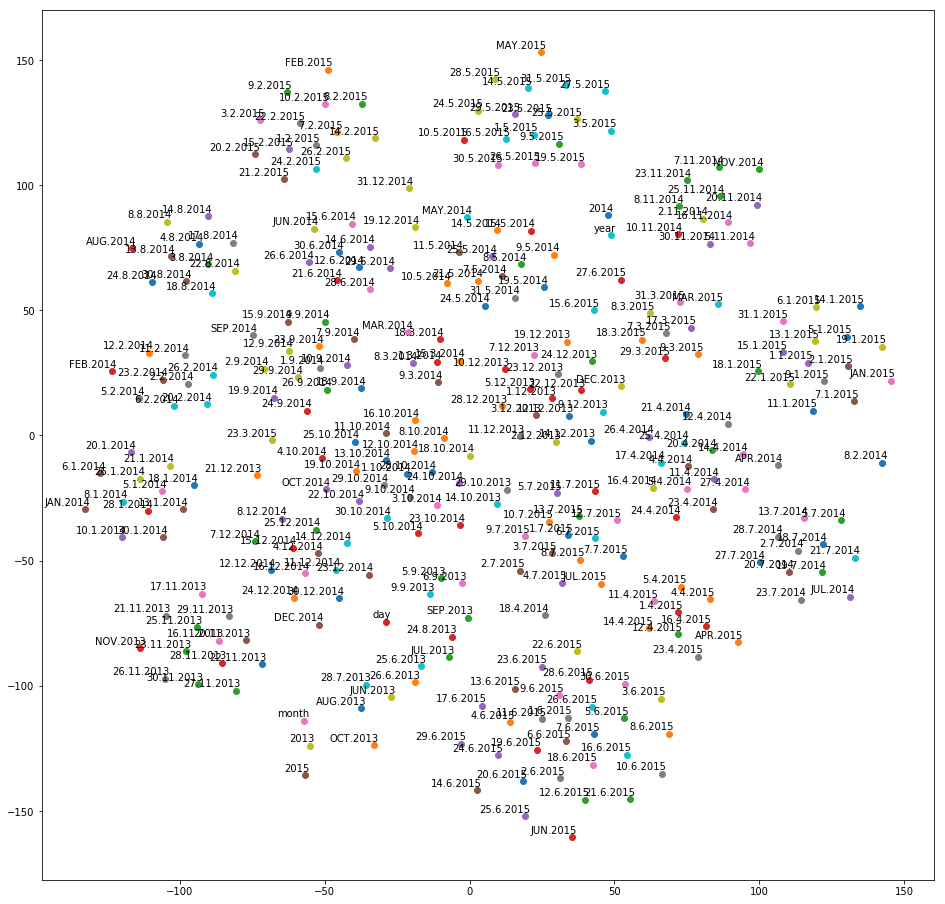

In [102]:
tsne_plot(G_time3_model)